### This notebook demostrates a non-linear multiple regression approach that is useful for many daily tasks of reservoir engineers estimating the value of horizontal multifrac'd wells. The example addresses the general estimation of EURs for potential drilling locations where analogous offsets and typical associated data are available.

In [1]:
# import relevant modules:

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit, differential_evolution
from scipy.stats import skew

import statsmodels.api as sm


# settings:

plt.rcParams['figure.figsize'] = (12,7)
sns.set()

---
## I'll use fake data for this demostration. I'll populate these commonly regarded fields:
<ul>
    <li>between-well spacing,
    <li>completion fluid volume, and 
    <li>completion sand volume.
</ul>

---

In [2]:
# add several fake well packages at various spacings:
spacing = np.concatenate([np.repeat(440, 12), 
                          np.repeat(660, 8),
                          np.repeat(880, 6), 
                          np.repeat(1056, 10),
                          np.repeat(1320, 8),
                          np.repeat(2640, 1)])

# add small random noise to the individual wells spacings:
spacing = spacing * np.random.normal(1, .1, len(spacing))

spacing

array([ 441.1513102 ,  398.80564762,  436.88075602,  431.09849319,
        436.18473462,  412.94662206,  468.30394012,  426.65112653,
        469.34040961,  459.01563266,  475.5877318 ,  383.20496903,
        547.96714324,  639.75344116,  840.29353465,  849.97712548,
        714.61002732,  699.58911428,  612.3646643 ,  797.44473436,
        769.05811595,  946.12987833,  938.78505468,  776.06636553,
       1063.99788171,  947.33883512,  907.20183083, 1017.32750843,
       1244.5931522 , 1000.60389767, 1158.80274497, 1033.4321496 ,
       1077.88689738, 1032.38481037, 1062.93457845, 1001.5521182 ,
       1242.58687834, 1119.56008939, 1474.42011235, 1294.88332837,
       1224.66341182, 1313.81329344, 1331.97866553, 1154.3756138 ,
       2598.73971036])

In [17]:
# create a dafatframe:
df = pd.DataFrame({'spacing': spacing})

# populate fake completions fluid volumes, defaulting to ~45 bbl/ft:
df['compl_bbl_per_ft'] = np.concatenate([np.repeat(45,6), np.repeat(33, 6), np.repeat(43, 8), np.repeat(42, 4), np.repeat(70, 2), 
               np.repeat(62, 3), np.repeat(45, 4), np.repeat(35, 3), np.repeat(45, 9)])

# add small random noise to the compl. fluid vols:
df['compl_bbl_per_ft'] = df['compl_bbl_per_ft'] + np.random.normal(1, 1, len(df))

# populate completion sand concentration as a random choice between three concentration rates (lbs 
# sand per bbls compl fluid) options, with a 3/5 preference for 40 lbs/bbl:
df['compl_sd_conc'] = np.random.choice([30, 40, 40, 40, 50], len(df))

# Add a sand load (lbs compl sand per foot) column. This is for familiar
# viewing only. Generally fluid load (lbs fluid / ft) and sand load (lbs sd per foot)
# will have problematic multicollinearity, so sand load will be omitted in the regression
# in favor of sand concentration.
df['compl_lbs_sd_per_ft'] = df['compl_bbl_per_ft'] * df['compl_sd_conc']

df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft
0,441.151310,46.341277,50,2317.063832
1,398.805648,46.877343,40,1875.093730
2,436.880756,45.869428,40,1834.777106
3,431.098493,46.371779,40,1854.871164
4,436.184735,46.829261,50,2341.463044
5,412.946622,45.444226,40,1817.769043
6,468.303940,34.747427,50,1737.371368
7,426.651127,34.089881,50,1704.494032
8,469.340410,34.764288,40,1390.571512
9,459.015633,34.369137,40,1374.765500


## Define a function for the initial population of fake well EURs, define a related cost function, and set related parameters.
### Utilize a modified sigmoid function, where
<ul>
    <li>L is the horizontal asymptote - the EUR for true stand-alone wells
    <li>k is the exponential factor - typically very small (k << 0.1)
    <li>b0 is the vertical axis intercept - the EUR two wells occupying the same position (zero spacing) would recover

In [18]:
k = 0.0025
L = 120
b0 = 60

# population function
# this is out underlying (synthetic) EUR/ft relationship
def mod_sig(spacing, k, L, b0):
    return L / (1 + np.exp(-k * (spacing - 0))) - L/2 + b0

# We expect error in EUR/ft to be lognormally distributed for a given state of
# the determinants we examine. So we define a cost function that allows the curve_fit
# algorithm to measure error against the log of EUR/ft, while still allowing us to 
# choose constraints for the algorithm which fit our intuitive understanding (linear
# space) of the reservoir & the data.

def cost(spacing, k, L, b0):
    return np.log(mod_sig(spacing, k, L, b0))

### Populate the fake EUR data & add noise

In [29]:
# adjust the EUR/ft by 8% for 25% change in sand concentration:
sd_conc_factor = 0.05 / .25

# adjust the EUR/ft by 20% for every 25% change in compl fluid per ft:
fluid_pft_factor = 0.1 / .25

df['eur_per_ft'] = df.apply(lambda x: mod_sig(x['spacing'], k, L, b0), axis=1)
df['eur_per_ft'] = (1 + ((df['compl_sd_conc'] - 40) / 40) * (sd_conc_factor)) * df['eur_per_ft']
df['eur_per_ft'] = (1 + ((df['compl_bbl_per_ft'] - 45) / 45) * (fluid_pft_factor)) * df['eur_per_ft']

eur_noise = np.random.lognormal(sigma=np.std(df['eur_per_ft']) / 10, size=len(df))

df['eur_per_ft'] = df['eur_per_ft'] + eur_noise

df = df.sort_values('spacing')

df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eur_per_ft
11,383.204969,34.075039,40,1363.001575,81.499547
1,398.805648,46.877343,40,1875.093730,95.416263
5,412.946622,45.444226,40,1817.769043,95.134161
7,426.651127,34.089881,50,1704.494032,85.860002
3,431.098493,46.371779,40,1854.871164,94.932047
4,436.184735,46.829261,50,2341.463044,96.159876
2,436.880756,45.869428,40,1834.777106,91.687193
0,441.151310,46.341277,50,2317.063832,101.867387
9,459.015633,34.369137,40,1374.765500,85.871282
6,468.303940,34.747427,50,1737.371368,87.872238


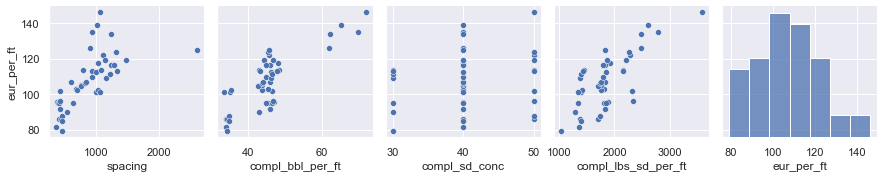

In [30]:
sns.pairplot(df, y_vars='eur_per_ft')

fit: k: 0.00240 
     L: 139.58 
     b0: 56.31


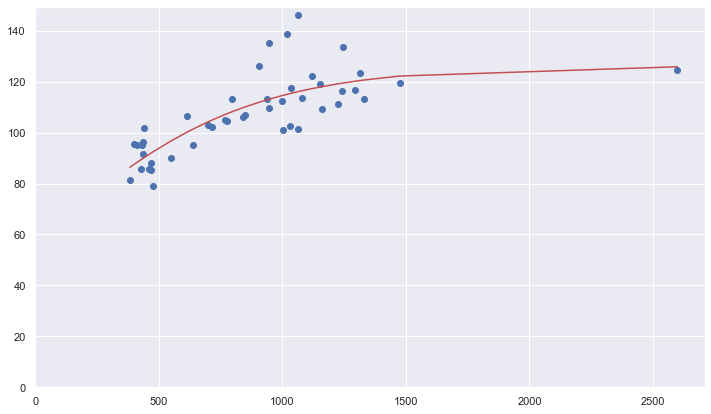

In [31]:
# define x & y space for the initial non-linear fit:
y = np.array(df['eur_per_ft'].values)
x = df['spacing'].values

# fit to log-space error:
popt, _ = curve_fit(cost, x, np.log(y), bounds=([0, 70, 0], [.1, 200, 100]))

# plot the curve fit vs. data
plt.scatter(x=x, y=y)
plt.plot(x, mod_sig(x, *popt), color='r')
plt.xlim(0,)
plt.ylim(0,)

print('fit: k: %1.5f \n     L: %1.2f \n     b0: %1.2f' % tuple(popt))

In [41]:
# define an array of error values:
err = y - mod_sig(x, *popt)

1.1137111555292543


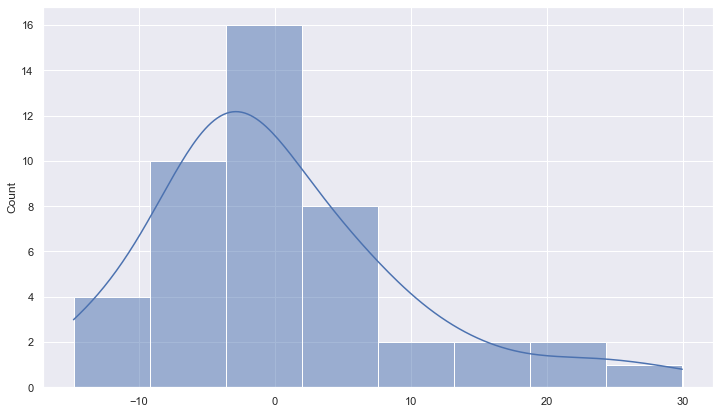

In [42]:
# examine the distribution of error (should be lognormally distributed)

sns.histplot(err, kde=True)

print(skew(err))

0.8290687842184362


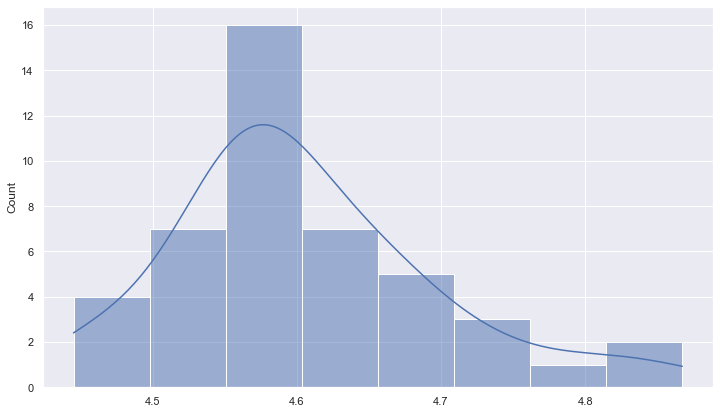

In [50]:
# further check for lognormality of error by examining ln(error) (should be roughly normal)
# the error has to be shifted in order to avoid errors due to ln(0)
trans_err = np.log(err + 100)

sns.histplot(trans_err, kde=True)
print(skew(trans_err))

In [51]:
# create a df for the remaining determinants,
# to be used in a linear ordinary least squares regression:
dfols = df[['compl_bbl_per_ft', 'compl_sd_conc']]
dfols['trans_err'] = trans_err
dfols

c:\envs\base\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,compl_bbl_per_ft,compl_sd_conc,trans_err
11,34.075039,40,4.555374
1,46.877343,40,4.682146
5,45.444226,40,4.670734
7,34.089881,50,4.570596
3,46.371779,40,4.657616
4,46.829261,50,4.666109
2,45.869428,40,4.622675
0,46.341277,50,4.715562
9,34.369137,40,4.549046
6,34.747427,50,4.563967


In [52]:
Xols = sm.add_constant(dfols.drop('trans_err', axis=1))
yols = dfols['trans_err']

In [53]:
ols = sm.OLS(yols, Xols)
ols_result = ols.fit()

In [54]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              trans_err   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     147.5
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           1.02e-19
Time:                        22:26:01   Log-Likelihood:                 91.141
No. Observations:                  45   AIC:                            -176.3
Df Residuals:                      42   BIC:                            -170.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.9684      0.041     95.741      0.000       3.885       4.052
compl_bbl_per_ft     0.0087      0.001     15.304      0.000       0.008       0.010
compl_sd_conc        0.0059      0.001      7.308      0.000       0.004       0.008
==============================================================================
Omnibus:                        3.416   Durbin-Watson:                   1.097
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.240
Skew:                           0.622   Prob(JB):                        0.198
Kurtosis:                       2.576   Cond. No.                         518.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
trial_fluid_load = 45
trial_sd_conc = 40
trial_spacing = 880

def predict_eur(spacing, fluid_load, sd_conc):
    return (mod_sig(spacing, *popt) + np.exp(ols_result.predict([1,fluid_load, sd_conc])) - 100)[0]

In [56]:
df['model_eur'] = df.apply(lambda x: predict_eur(x['spacing'], x['compl_bbl_per_ft'], x['compl_sd_conc']), axis=1)
df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eur_per_ft,model_eur
11,383.204969,34.075039,40,1363.001575,81.499547,76.496561
1,398.805648,46.877343,40,1875.093730,95.416263,88.199132
5,412.946622,45.444226,40,1817.769043,95.134161,87.890950
7,426.651127,34.089881,50,1704.494032,85.860002,84.883742
3,431.098493,46.371779,40,1854.871164,94.932047,89.888696
4,436.184735,46.829261,50,2341.463044,96.159876,96.736222
2,436.880756,45.869428,40,1834.777106,91.687193,89.823937
0,441.151310,46.341277,50,2317.063832,101.867387,96.601840
9,459.015633,34.369137,40,1374.765500,85.871282,81.699862
6,468.303940,34.747427,50,1737.371368,87.872238,88.084015
